In [1]:
import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib as mpl
import matplotlib.pyplot as plt
# from scipy.interpolate import griddata
# from scipy.interpolate import RBFInterpolator
from tqdm import tqdm
# import open3d as o3d
import os
from pyquaternion import Quaternion
# from floorplan_utils import *
# from img_utils import *

In [2]:
def ralign(X, Y):
    m, n = X.shape

    mx = X.mean(1)
    my = Y.mean(1)

    Xc = X - mx[..., None]
    Yc = Y - my[..., None]

    sx = Xc.var(1).sum()
    sy = Yc.var(1).sum()

    Sxy = np.dot(Yc, Xc.T) / n

    S = np.ones(m)
    if np.linalg.det(Sxy) < 0:
        S[m - 1] = -1

    U, D, V = np.linalg.svd(Sxy)

    r = np.linalg.matrix_rank(Sxy)

    if r >= (m - 1):
        if r == m - 1:
            if np.linalg.det(U) * np.linalg.det(V) > 0:
                R = np.dot(U, V)
            else:
                s_ = S[m - 1]
                S[m - 1] = -1
                R = np.dot(U, np.dot(np.diag(S), V))
                S[m - 1] = s_
        else:
            R = np.dot(U, np.dot(np.diag(S), V))
    else:
        return (None, None, None, None)

    DS = np.dot(D, S)

    c = DS / sx
    t = my - c * np.dot(R, mx)

    e = sy - DS**2 / sx

    return R, c, t, e

In [3]:
mpl.rcParams['figure.figsize'] = [15, 15]

In [4]:
# data_root = '/home/lipeize/catkin_liosam/saves/'
# seqs = ['2023-02-02-18-52-57-seq6-f0', 
#         '2023-02-02-19-03-11-seq7-f0', 
#         '2023-02-02-19-12-55-seq8-f0', 
#         '2023-02-02-19-24-52-seq9-f1', 
#         '2023-02-02-19-35-47-seq10-f1',
#         '2023-02-02-19-46-24-seq11-f1']
# seq_idx = 0
data_root = '../data/'
seqs = ['3','6','7','9']
seq_idx = 3

Read LAST line of path file.

In [5]:
# with open(os.path.join(data_root, seqs[seq_idx], 'path.csv'), 'r') as f:
#     lines = f.read().splitlines()
#     last_line = lines[-1]
# path = last_line.split(',')
path = np.load(data_root+seqs[seq_idx]+ '.npy')
# path = np.array(path[4:]).reshape([-1, 10])
# path = np.delete(path, 2, 1)
path = path.astype(float)
# gt_path = path[:, 2:5]

In [6]:
seq_duration = (path[-1, 1] - path[0, 1]) / 1e9
print(seq_duration)

1.3541021260534763e-09


(-24.703790855407714, 40.97508068084717, -42.15336766242981, 17.97883095741272)

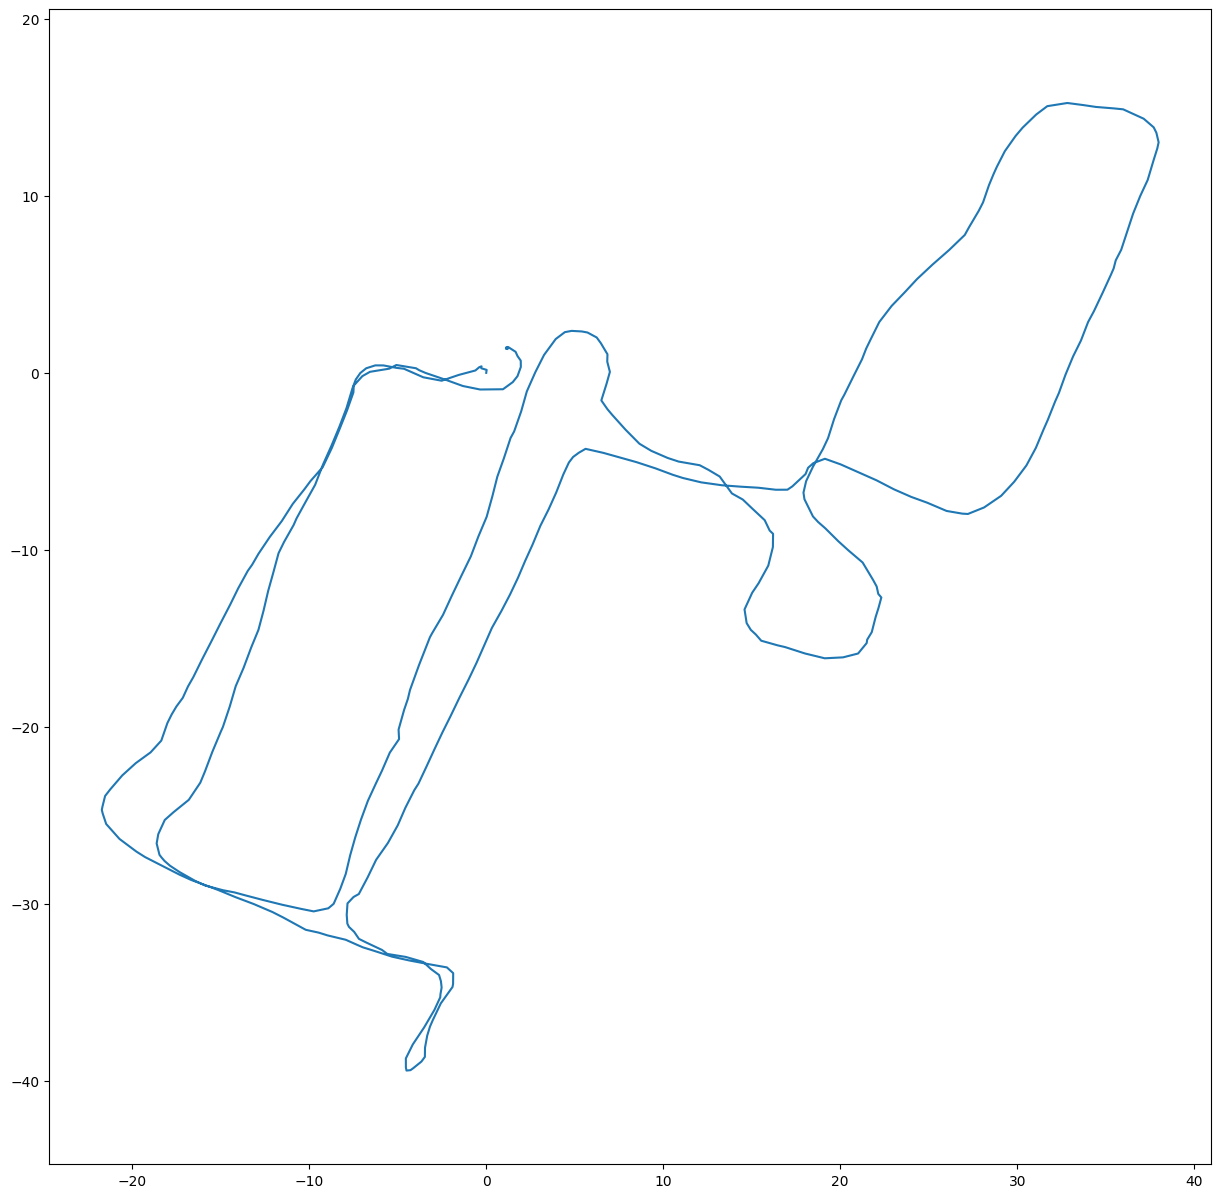

In [7]:
plt.plot(path[:, 0], path[:, 1])
plt.axis('equal')

In [8]:
# corners_gt = np.array([[5.944540, 39.708279, -0.520508],
#  [25.561304, 9.863537, -0.466914],
#  [-3.859824, -6.034390, 0.085863],
# [12.924220, -30.910660, 0.450827]])

# corners_gt = np.array([[-14.550963, 11.512155, -0.848353], 
#                        [11.399657, 30.526108, -0.594791], 
#                        [14.986525, 7.845741, -1.207359], 
#                        [3.370856, -4.656131, -1.457701]])

# x = corners_gt[:,0]
# y = corners_gt[:,1]
# plt.scatter(x, y)

# corners_gt = np.array([[2.959888, 46.526699, 0.384468],
# [39.828835, -7.806488, -1.175075],
# [15.363974, -38.455940, 1.737134],
# [-8.250896, -8.302032, 2.217922]])


# corners_gt = np.array([[2.959888, 46.526699, 0.384468],
#  [39.828835, -7.806488, -1.175075],
#  [15.363974, -38.455940, 1.737134],
# [-8.250896, -8.302032, 2.217922]])

corners_gt = np.array([[45.893250, 18.194370, 3.626997],
[28.937674, -21.835167, 2.812950],
 [-27.697651, -30.026049, 1.746614],
[-10.586970, 2.813083, -0.689345]])

# Point index picked: 86976 (real: 86976) - [6.472130, 39.414200, 0.478048]
# Point index picked: 64020 (real: 64020) - [33.364693, 14.977477, 0.279529]
# Point index picked: 15466 (real: 15466) - [15.117744, -38.073227, 3.057659]
# Point index picked: 37695 (real: 37695) - [-8.708307, -8.988010, 0.862633]

In [9]:
# corners_map = np.array([[523, -431, 0], 
#                         [1427, -365, 0], 
#                         [1165, -960, 0], 
#                         [693, -1088, 0]])

corners_map = np.array([[1006, 2350, 0], 
                        [4343, 1463, 0], 
                        [7627, 4494, 0], 
                        [4714, 5291, 0]])

# corners_map = np.array([
# [194,532, 0], 
# [1170,260, 0], 
# [2137,1187, 0], 
# [1282,1428, 0]])
# corners_map[:,0] = corners_map[:,0] - 9362/2 
# corners_map[:,1] = 6623/2 - corners_map[:,1]
corners_map[:,1] = corners_map[:,1]*-1
# corners_map = corners_map/80
# corners_map = corners_map /72/39.37 * 100
corners_map

array([[ 1006, -2350,     0],
       [ 4343, -1463,     0],
       [ 7627, -4494,     0],
       [ 4714, -5291,     0]])

In [10]:
print(np.linalg.norm(corners_gt[0] - corners_gt[1]))
print(np.linalg.norm(corners_gt[1] - corners_gt[2]))
print(np.linalg.norm(corners_gt[2] - corners_gt[3]))
print(np.linalg.norm(corners_gt[3] - corners_gt[0]))

43.4800881144962
57.23449709972513
37.1095390842687
58.69608206077926


In [11]:
print(np.linalg.norm(corners_map[0] - corners_map[1]))
print(np.linalg.norm(corners_map[1] - corners_map[2]))
print(np.linalg.norm(corners_map[2] - corners_map[3]))
print(np.linalg.norm(corners_map[3] - corners_map[0]))
print("/scale")
corners_map = corners_map /200/39.37 * 100
print(np.linalg.norm(corners_map[0] - corners_map[1]))
print(np.linalg.norm(corners_map[1] - corners_map[2]))
print(np.linalg.norm(corners_map[2] - corners_map[3]))
print(np.linalg.norm(corners_map[3] - corners_map[0]))

x = 9362/200/39.37 * 100
y = 6623/200/39.37 * 100

x

3452.8738754840147
4468.96151247692
3020.062582133026
4732.731241048872
/scale
43.85158592181883
56.755924720306325
38.35487150283243
60.10580697293462


118.8976377952756

In [12]:
alignment = ralign(corners_gt.T, corners_map.T)
print(alignment)

(array([[-6.22593470e-01, -7.82545406e-01,  2.40756198e-04],
       [ 7.80460620e-01, -6.20912312e-01,  7.31376801e-02],
       [-5.70840671e-02,  4.57229428e-02,  9.97321825e-01]]), 1.0119543693135584, array([ 55.81350339, -55.37506261,  -1.00694537]), 1.980696292512448)


In [13]:
q = Quaternion(matrix=alignment[0])

In [14]:
gt_matched = []
# for i in gt_path:
for i in path:
    gt_matched.append(q.rotate(i) + alignment[2])
gt_matched = np.array(gt_matched)

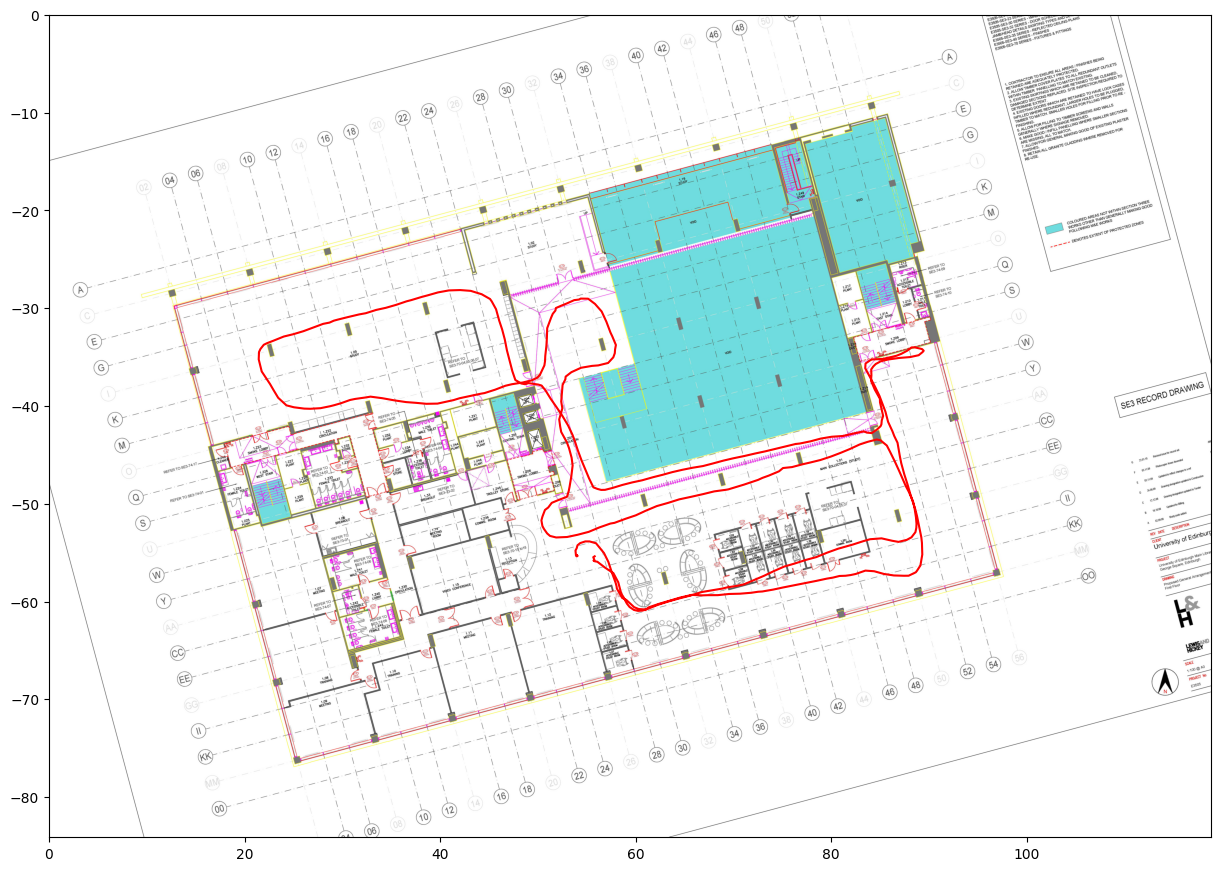

In [15]:
maxx= 9362/200/39.37 * 100
maxy= -6623/200/39.37 * 100
fig, ax = plt.subplots()
im = plt.imread("../2.png")
im = ax.imshow(im, extent=[0, maxx, maxy, 0])
ax.plot(gt_matched[:, 0], gt_matched[:, 1], c='r')

In [16]:
ts = path[:,1] / 1e7 - 1.675346097874434204e11
out = np.hstack((ts.reshape((-1, 1)), gt_matched[:,0:2]))
np.save(os.path.join(data_root, seqs[seq_idx], 'gt.npy'), out)

FileNotFoundError: [Errno 2] No such file or directory: '../data/9\\gt.npy'

In [ ]:
from scipy import interpolate
fx = interpolate.interp1d(out[:,0], out[:,1])
fy = interpolate.interp1d(out[:,0], out[:,2])
ts_new = np.arange(out[0,0], out[-1,0], 10)
out_interpolate = np.hstack((ts_new.reshape((-1, 1)), fx(ts_new).reshape((-1, 1)), fy(ts_new).reshape((-1, 1))))
np.save(os.path.join(data_root, seqs[seq_idx], 'gt_interpolate.npy'), out_interpolate)

FileNotFoundError: [Errno 2] No such file or directory: '../data/3\\gt_interpolate.npy'

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/workdir/huawei_ips/F0_corrected_72.png'

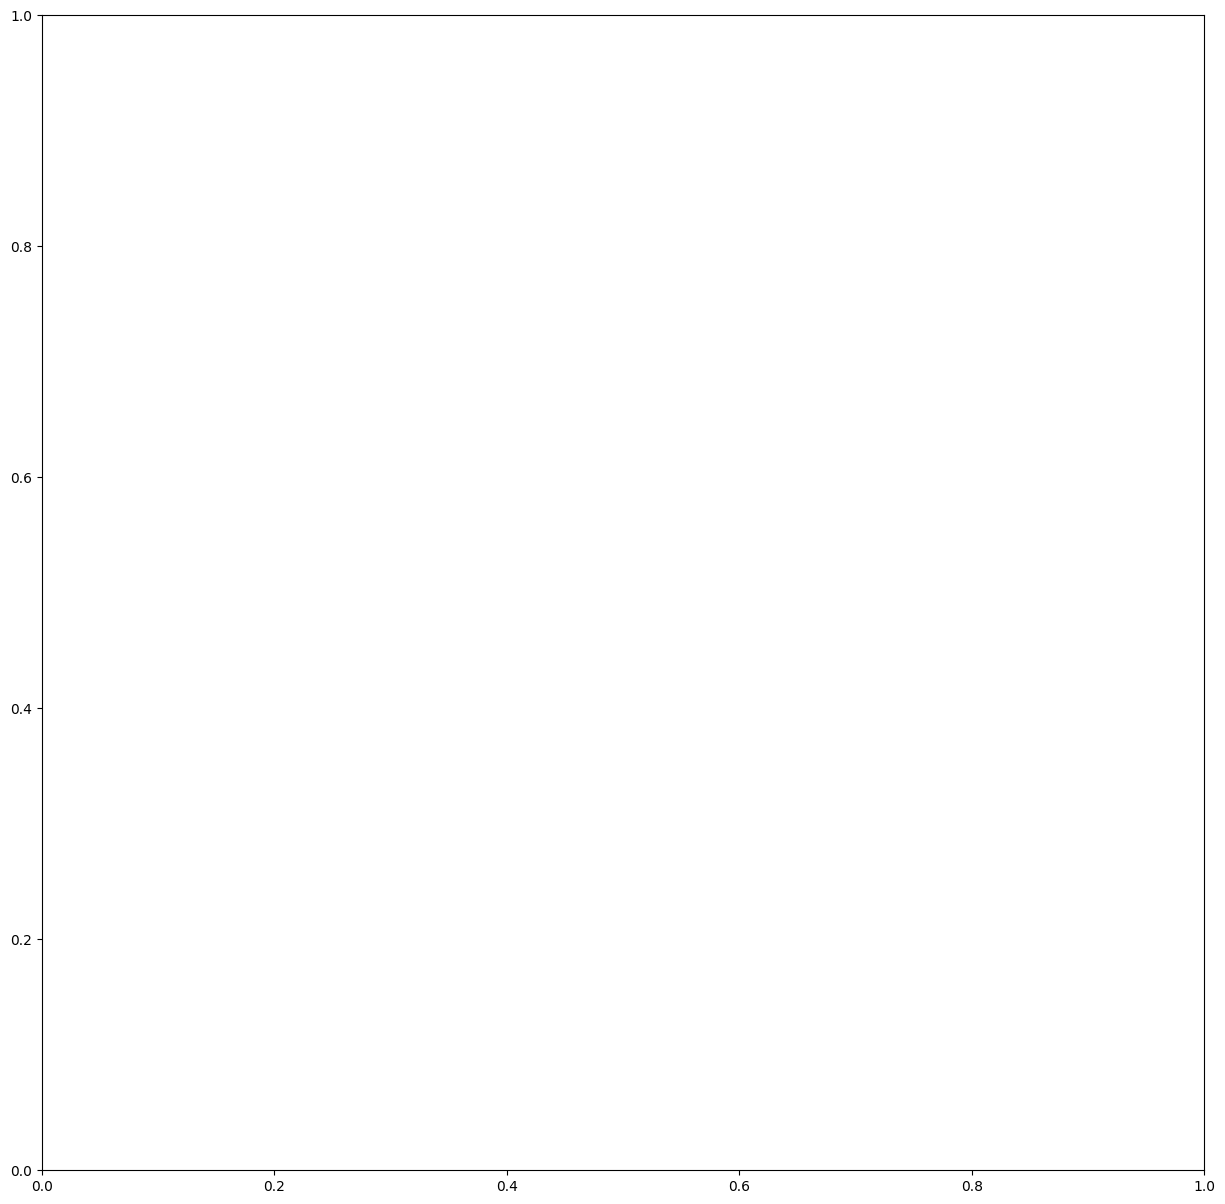

In [ ]:
fig, ax = plt.subplots()
im = plt.imread("/mnt/workdir/huawei_ips/F0_corrected_72.png")
im = ax.imshow(im, extent=[0, maxx, maxy, 0])
ax.plot(out_interpolate[:, 1], out_interpolate[:, 2], c='r')

In [ ]:
out